In [21]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [22]:
import torch
train_images = "/kaggle/input/highway-lane-segmentation/highway_train/highway_train/images"
train_masks = "/kaggle/input/highway-lane-segmentation/highway_train/highway_train/masks"
# determine the device to be used for training and evaluation
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# determine if we will be pinning memory during data loading
PIN_MEMORY = True if DEVICE == "cuda" else False

In [23]:
# define the number of channels in the input, number of classes,
# and number of levels in the U-Net model
NUM_CHANNELS = 1
NUM_CLASSES = 1
NUM_LEVELS = 3
# initialize learning rate, number of epochs to train for, and the
# batch size
INIT_LR = 0.01
NUM_EPOCHS = 20

BATCH_SIZE = 32
# define the input image dimensions
INPUT_IMAGE_WIDTH = 256
INPUT_IMAGE_HEIGHT = 256
# define threshold to filter weak predictions
THRESHOLD = 0.5
# define the path to the base output directory
BASE_OUTPUT = "output"
# define the path to the output serialized model, model training
# plot, and testing image paths
MODEL_PATH = os.path.join(BASE_OUTPUT, "unet_tgs_salt.pth")
PLOT_PATH = os.path.sep.join([BASE_OUTPUT, "plot.png"])
TEST_PATHS = os.path.sep.join([BASE_OUTPUT, "test_paths.txt"])

In [24]:
train_images_list = sorted(os.listdir(train_images))
train_masks_list = sorted(os.listdir(train_masks))

In [25]:
print(len(train_images_list))
print(len(train_masks_list))

900
900


In [26]:
print(train_images_list[:5])
print(train_masks_list[:5])

['TrainSeq00_RGB_Image_0000.png', 'TrainSeq00_RGB_Image_0001.png', 'TrainSeq00_RGB_Image_0002.png', 'TrainSeq00_RGB_Image_0003.png', 'TrainSeq00_RGB_Image_0004.png']
['TrainSeq00_ClassId_0000.png', 'TrainSeq00_ClassId_0001.png', 'TrainSeq00_ClassId_0002.png', 'TrainSeq00_ClassId_0003.png', 'TrainSeq00_ClassId_0004.png']


In [27]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import cv2
from PIL import Image

class HighwayData(Dataset):
    def __init__(self,images_path,masks_path,images_list,masks_list,transforms=None):
        self.images_path = images_path
        self.masks_path = masks_path
        self.images_list = images_list
        self.masks_list = masks_list
        self.transforms = transforms
            
    
    def __len__(self):
        return len(self.images_list)
        
    def __getitem__(self,idx):
        image_path = os.path.join(self.images_path,self.images_list[idx])
        mask_path = os.path.join(self.masks_path,self.masks_list[idx])
        image = cv2.imread(image_path)
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path,0)
        
        if self.transforms is not None:
            # apply the transformations to both image and its mask
            image = self.transforms(image)
            mask = self.transforms(mask)
        return image,mask
        

In [28]:
from sklearn.model_selection import train_test_split
# define transformations
transforms = transforms.Compose([transforms.ToPILImage(),
 	transforms.Resize((256,256)),
	transforms.ToTensor()])


# create the train and test datasets
Data = HighwayData(images_path=train_images, masks_path=train_masks,images_list=train_images_list, masks_list=train_masks_list,transforms=transforms)
train_size = int(0.8 * len(Data))
val_size = len(Data) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(Data, [train_size, val_size])

In [29]:
# create the training and test data loaders
trainLoader = DataLoader(train_dataset, shuffle=True,
	batch_size=2,
    pin_memory=PIN_MEMORY,
	num_workers=os.cpu_count())
testLoader = DataLoader(val_dataset, shuffle=False,
	batch_size=2,
    pin_memory=PIN_MEMORY,
	num_workers=os.cpu_count())


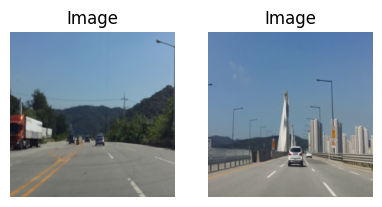

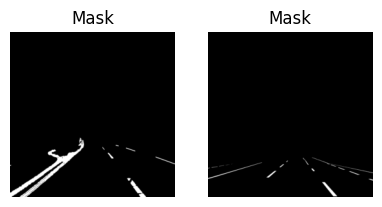

In [30]:
import matplotlib.pyplot as plt

# Define a function to display images and masks in a grid
def show_images_masks_grid(images, masks, num_cols=8):
    num_images = images.size(0)
    num_rows = (num_images + num_cols - 1) // num_cols

    plt.figure(figsize=(20, 10))
    for i in range(num_images):
        plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(images[i].permute(1, 2, 0))  # Convert tensor to numpy array and permute dimensions
        plt.title('Image')
        plt.axis('off')

    plt.figure(figsize=(20, 10))
    for i in range(num_images):
        plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(masks[i].squeeze(), cmap='gray')  # Assuming the mask is a single-channel image
        plt.title('Mask')
        plt.axis('off')

    plt.show()


for images,masks in iter(trainLoader):
    show_images_masks_grid(images, masks)
    break

In [31]:
import torch
import torch.nn as nn

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(UNet, self).__init__()
        
        # Down sampling
        self.down_conv1 = self.double_conv(in_channels, 64)
        self.down_pool1 = nn.MaxPool2d(2, 2)
        self.down_conv2 = self.double_conv(64, 128)
        self.down_pool2 = nn.MaxPool2d(2, 2)
        self.down_conv3 = self.double_conv(128, 256)
        self.down_pool3 = nn.MaxPool2d(2, 2)
        self.down_conv4 = self.double_conv(256, 512)
        self.down_pool4 = nn.MaxPool2d(2, 2)
        self.down_conv5 = self.double_conv(512, 1024)
        
        # Up sampling
        self.up_transpose1 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.up_conv1 = self.double_conv(1024, 512)
        self.up_transpose2 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.up_conv2 = self.double_conv(512, 256)
        self.up_transpose3 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.up_conv3 = self.double_conv(256, 128)
        self.up_transpose4 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.up_conv4 = self.double_conv(128, 64)
        
        # Final output convolution
        self.out_conv = nn.Conv2d(64, out_channels, 1)
        
    def forward(self, x):
        # Down sampling
        down1 = self.down_conv1(x)
        down_pool1 = self.down_pool1(down1)
        down2 = self.down_conv2(down_pool1)
        down_pool2 = self.down_pool2(down2)
        down3 = self.down_conv3(down_pool2)
        down_pool3 = self.down_pool3(down3)
        down4 = self.down_conv4(down_pool3)
        down_pool4 = self.down_pool4(down4)
        down5 = self.down_conv5(down_pool4)
        
        # Up sampling
        up1 = self.up_transpose1(down5)
        up1 = self.crop_and_concat(up1, down4)
        up1 = self.up_conv1(up1)
        up2 = self.up_transpose2(up1)
        up2 = self.crop_and_concat(up2, down3)
        up2 = self.up_conv2(up2)
        up3 = self.up_transpose3(up2)
        up3 = self.crop_and_concat(up3, down2)
        up3 = self.up_conv3(up3)
        up4 = self.up_transpose4(up3)
        up4 = self.crop_and_concat(up4, down1)
        up4 = self.up_conv4(up4)
        
        # Final output
        out = self.out_conv(up4)
        return out
    
    def double_conv(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    def crop_and_concat(self, upsampled, bypass):
        """
        Crop `bypass` feature map and concatenate it with the `upsampled` feature map
        """
        diff_y = bypass.size()[2] - upsampled.size()[2]
        diff_x = bypass.size()[3] - upsampled.size()[3]
        upsampled = nn.functional.pad(upsampled, (diff_x // 2, diff_x - diff_x // 2,
                                                  diff_y // 2, diff_y - diff_y // 2))
        return torch.cat([bypass, upsampled], 1)


def dice_coef(y_true, y_pred, smooth=1):
    intersection = torch.sum(y_true * y_pred)
    union = torch.sum(y_true) + torch.sum(y_pred)
    dice = (2. * intersection + smooth) / (union + smooth)
    return dice

def dice_loss(y_true, y_pred):
    loss = 1 - dice_coef(y_true, y_pred)
    return loss

def precision(y_true, y_pred):
    true_positives = torch.sum(torch.round(torch.clip(y_true * y_pred, 0, 1)))
    
# Part 3 - Training

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the model
model = UNet().to(device)

In [32]:
# Define loss function and optimizer
criterion = dice_loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# Define your training loop where you track the best validation loss
best_val_loss = float('inf')  # Initialize with a large value
best_model_path = "/kaggle/working/best_model.pth"  # Path to save the best model

In [35]:
# Define loss function and optimizer
criterion = dice_loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Define your training loop where you track the best validation loss
best_val_loss = float('inf')  # Initialize with a large value
best_model_path = "/kaggle/working/best_model.pth"  # Path to save the best model
from tqdm import tqdm

# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    train_running_loss = 0.0
    for images, masks in tqdm(trainLoader, desc=f'Epoch {epoch+1}/{num_epochs}', leave=False):
        images, masks = images.to(device), masks.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, masks)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update statistics
        train_running_loss += loss.item() * images.size(0)

    # Calculate average training loss
    train_loss = train_running_loss / len(trainLoader.dataset)
    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_loss:.4f}')

    # Validation loop
    model.eval()
    val_running_loss = 0.0
    with torch.no_grad():
        val_running_loss = 0.0
        for images, masks in tqdm(testLoader, desc='Validation', leave=False):
            images, masks = images.to(device), masks.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, masks)

            # Update statistics
            val_running_loss += loss.item() * images.size(0)
            
        


    # Calculate validation loss
    val_loss = val_running_loss / len(testLoader.dataset)
    # Check if this is the best model so far
    if val_loss < best_val_loss and val_loss > 0:
        best_val_loss = val_loss
        torch.save(model.state_dict(), best_model_path)
        print("Best model saved with validation loss: {:.4f}".format(best_val_loss))
    print(f'Epoch [{epoch+1}/{num_epochs}], Validation Loss: {val_loss:.4f}')

# # After training, load the best model
# model = UNet()
# model.load_state_dict(torch.load(best_model_path))

Epoch [1/50], Training Loss: 0.8172


Best model saved with validation loss: 0.9822
Epoch [1/50], Validation Loss: 0.9822


Epoch [2/50], Training Loss: 1.0059


Epoch [2/50], Validation Loss: 1.0049


Epoch [3/50], Training Loss: 0.9800


Epoch [3/50], Validation Loss: 1.0200


Epoch [4/50], Training Loss: 0.8461


Epoch [4/50], Validation Loss: 1.0034


Epoch [5/50], Training Loss: 0.8770


Epoch [5/50], Validation Loss: 0.9910


Epoch [6/50], Training Loss: 0.9838


Epoch [6/50], Validation Loss: 0.9896


Epoch [7/50], Training Loss: 0.9803


Best model saved with validation loss: 0.9822
Epoch [7/50], Validation Loss: 0.9822


Epoch [8/50], Training Loss: 0.9717


Best model saved with validation loss: 0.9685
Epoch [8/50], Validation Loss: 0.9685


Epoch [9/50], Training Loss: 0.9557


Best model saved with validation loss: 0.9431
Epoch [9/50], Validation Loss: 0.9431


Epoch [10/50], Training Loss: 0.9268


Best model saved with validation loss: 0.9195
Epoch [10/50], Validation Loss: 0.9195


Epoch [11/50], Training Loss: 0.8869


Best model saved with validation loss: 0.8938
Epoch [11/50], Validation Loss: 0.8938


Epoch [12/50], Training Loss: 0.8441


Best model saved with validation loss: 0.8275
Epoch [12/50], Validation Loss: 0.8275


Epoch [13/50], Training Loss: 0.7466


Best model saved with validation loss: 0.6369
Epoch [13/50], Validation Loss: 0.6369


Epoch [14/50], Training Loss: 0.3436


Epoch [14/50], Validation Loss: 0.7002


Epoch [15/50], Training Loss: 0.6910


Epoch [15/50], Validation Loss: 1.1177


Epoch [16/50], Training Loss: 1.0508


Epoch [16/50], Validation Loss: 0.9986


Epoch [17/50], Training Loss: 0.9984


Epoch [17/50], Validation Loss: 0.9978


Epoch [18/50], Training Loss: 0.9973


Epoch [18/50], Validation Loss: 0.9965


Epoch [19/50], Training Loss: 0.9962


Epoch [19/50], Validation Loss: 0.9942


Epoch [20/50], Training Loss: 0.9955


Epoch [20/50], Validation Loss: 0.9922


Epoch [21/50], Training Loss: 0.9942


Epoch [21/50], Validation Loss: 0.9887


Epoch [22/50], Training Loss: 0.9936


Epoch [22/50], Validation Loss: 0.9927


Epoch [23/50], Training Loss: 0.9930


Epoch [23/50], Validation Loss: 0.9904


Epoch [24/50], Training Loss: 0.9924


Epoch [24/50], Validation Loss: 0.9929


Epoch [25/50], Training Loss: 0.9915


Epoch [25/50], Validation Loss: 0.9922


Epoch [26/50], Training Loss: 0.9910


Epoch [26/50], Validation Loss: 0.9908


Epoch [27/50], Training Loss: 0.9901


Epoch [27/50], Validation Loss: 0.9892


Epoch [28/50], Training Loss: 0.9889


Epoch [28/50], Validation Loss: 0.9876


Epoch [29/50], Training Loss: 0.9875


Epoch [29/50], Validation Loss: 0.9866


Epoch [30/50], Training Loss: 0.9855


Epoch [30/50], Validation Loss: 0.9838


Epoch [31/50], Training Loss: 0.9832


Epoch [31/50], Validation Loss: 0.9751


Epoch [32/50], Training Loss: 0.9802


Epoch [32/50], Validation Loss: 0.9764


Epoch [33/50], Training Loss: 0.9757


Epoch [33/50], Validation Loss: 0.9640


Epoch [34/50], Training Loss: 0.9631


Epoch [34/50], Validation Loss: 0.9591


Epoch [35/50], Training Loss: 0.8844


Epoch [35/50], Validation Loss: 0.9127


Epoch [36/50], Training Loss: 0.9082


Epoch [36/50], Validation Loss: 0.9259


Epoch [37/50], Training Loss: 0.9054


Epoch [37/50], Validation Loss: 0.8737


Epoch [38/50], Training Loss: 0.6356


Epoch [38/50], Validation Loss: 0.8646


Epoch [39/50], Training Loss: 0.3249


Epoch [39/50], Validation Loss: 0.9135


Epoch [40/50], Training Loss: 0.8260


Epoch [40/50], Validation Loss: 1.0828


Epoch [41/50], Training Loss: 0.9148


Epoch [41/50], Validation Loss: 1.5392


Epoch [42/50], Training Loss: 1.0071


Epoch [42/50], Validation Loss: 1.4172


Epoch [43/50], Training Loss: 1.0033


Epoch [43/50], Validation Loss: 1.0861


Epoch [44/50], Training Loss: 0.9998


Epoch [44/50], Validation Loss: 1.0664


Epoch [45/50], Training Loss: 0.9962


Epoch [45/50], Validation Loss: 1.5117


Epoch [46/50], Training Loss: 0.9926


Epoch [46/50], Validation Loss: 1.0165


Epoch [47/50], Training Loss: 0.9853


Epoch [47/50], Validation Loss: 0.9371


Epoch [48/50], Training Loss: 0.9708


Epoch [48/50], Validation Loss: 0.9173


Epoch [49/50], Training Loss: 2.4600


Epoch [49/50], Validation Loss: 0.9534


Epoch [50/50], Training Loss: 0.9508


Epoch [50/50], Validation Loss: 0.9540


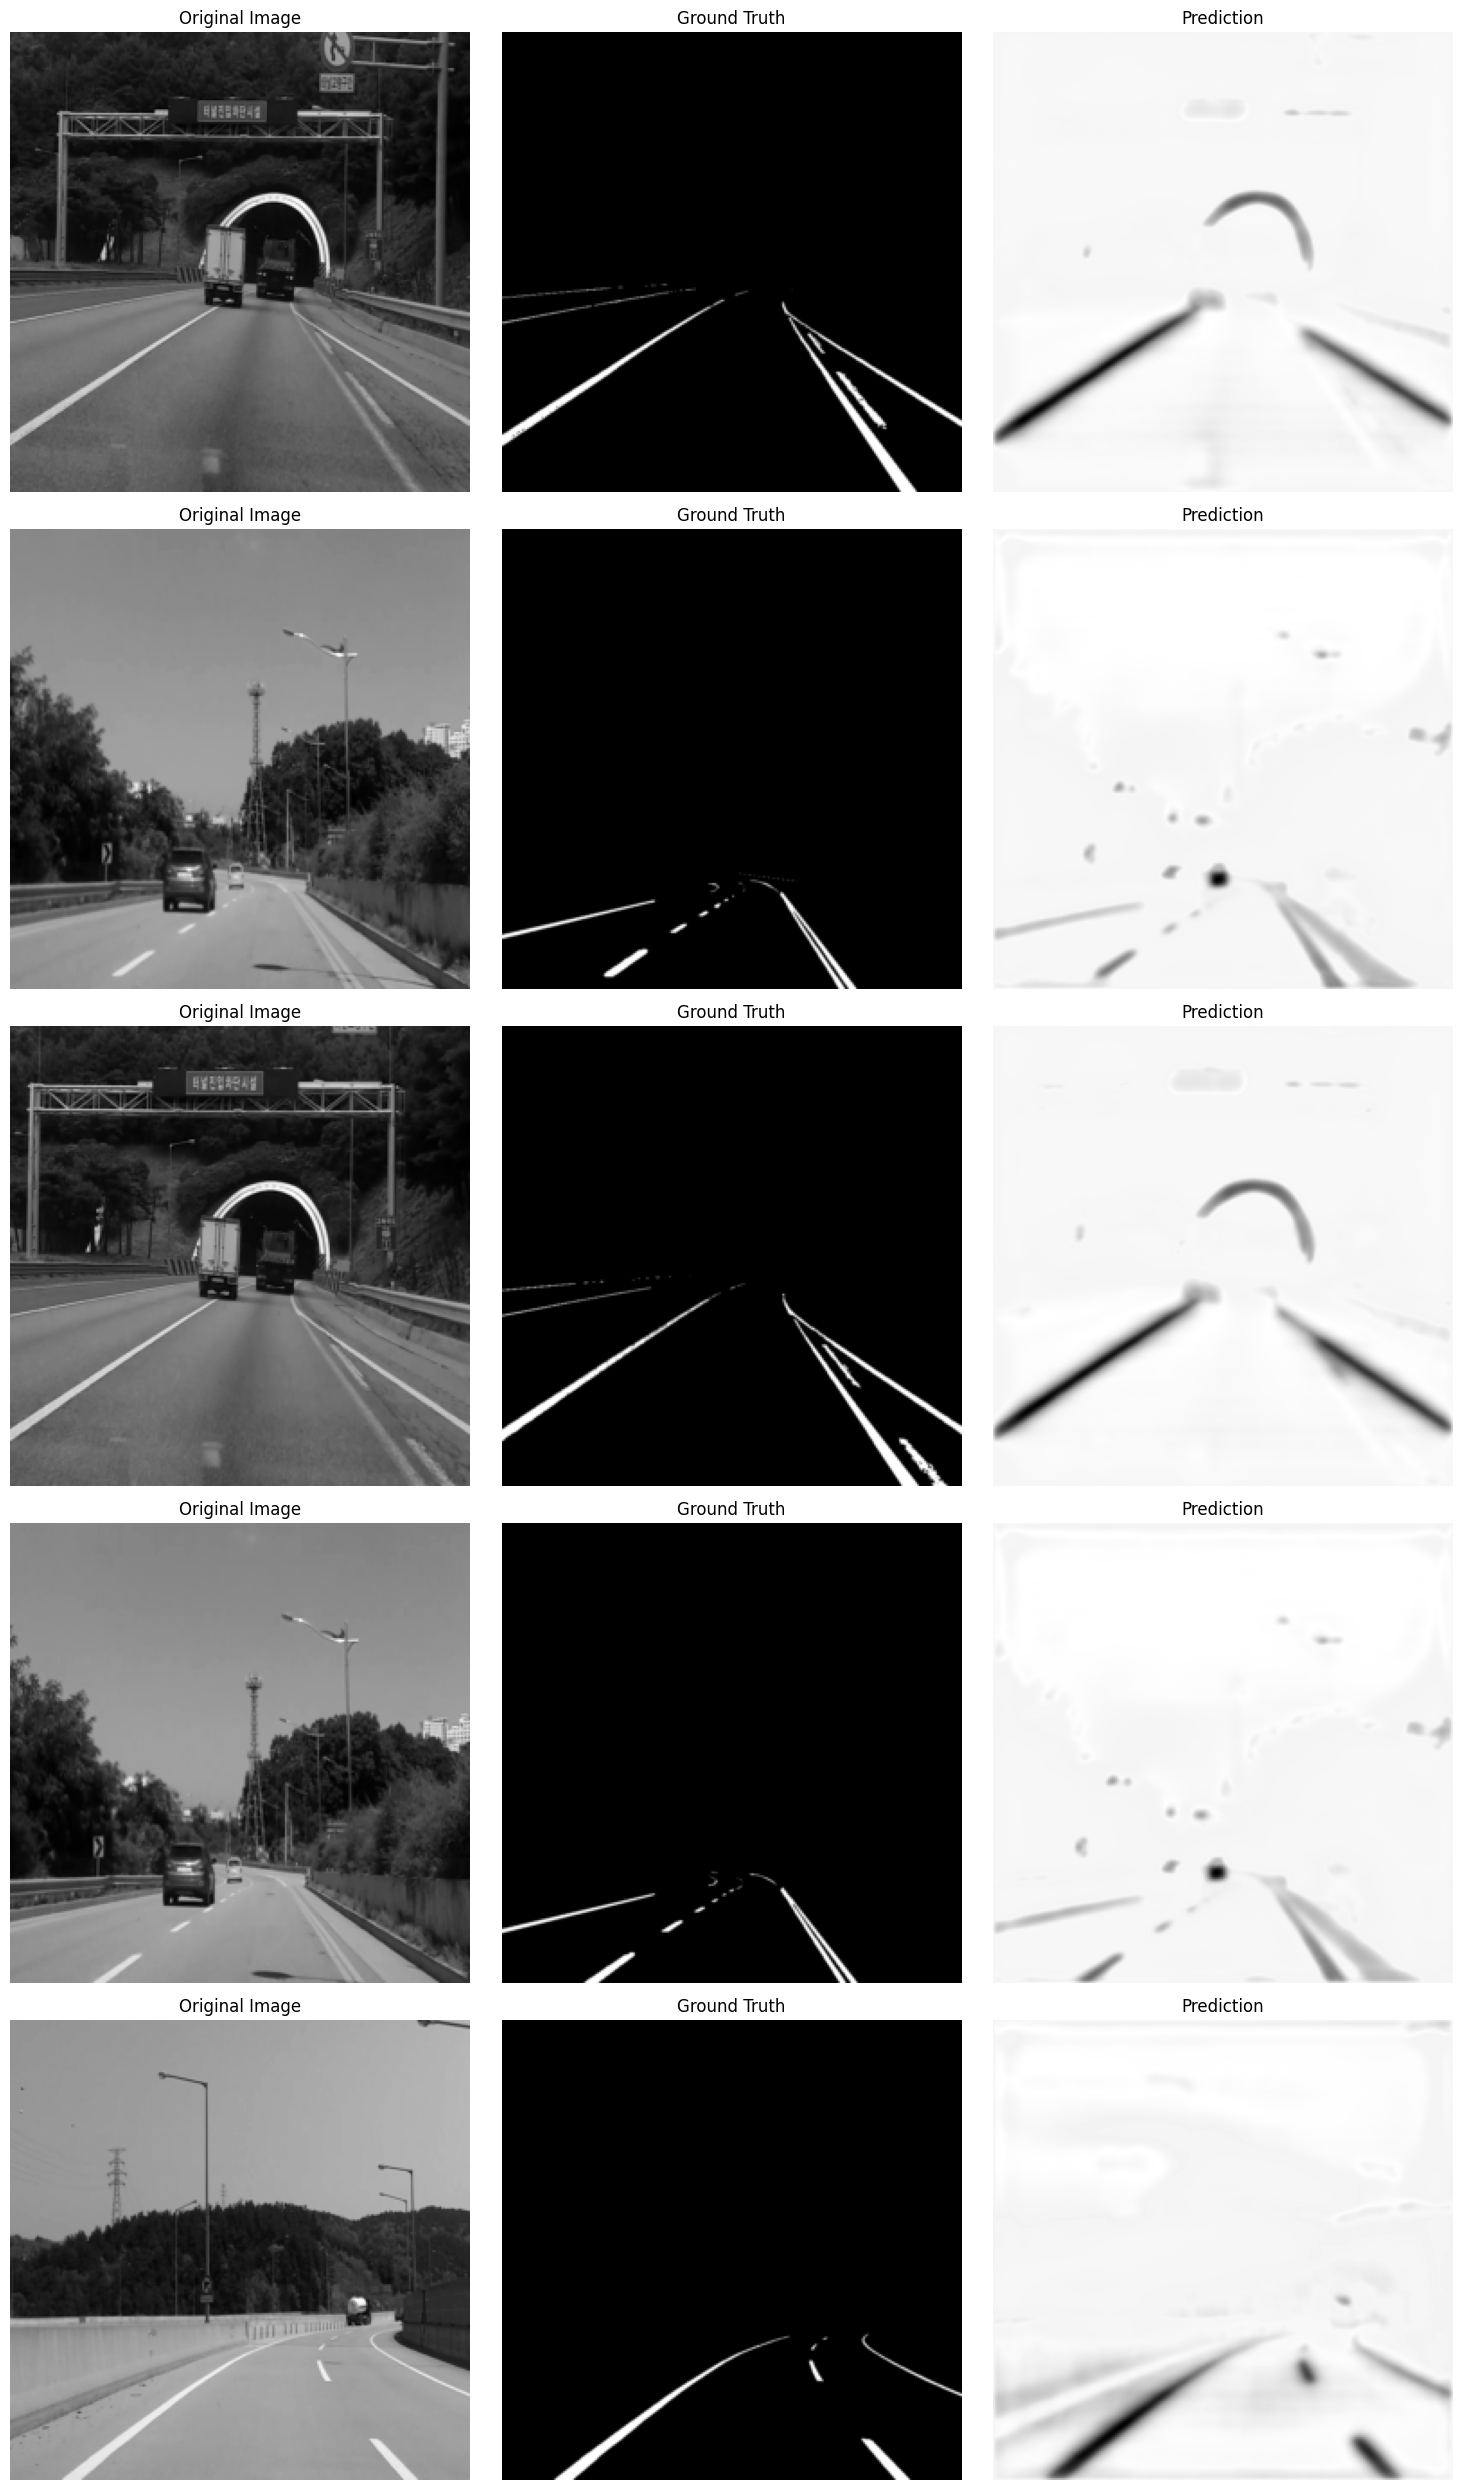

In [37]:
import matplotlib.pyplot as plt
import torch
import numpy as np

# After training, load the best model
unet = UNet().to(device)
unet.load_state_dict(torch.load(best_model_path))

# Set the model to evaluation mode
unet.eval()

# Choose some random samples from the validation dataset
num_samples_to_display = 5
samples_to_display = torch.utils.data.Subset(val_dataset, torch.randint(0, len(val_dataset), (num_samples_to_display,)))

# Create a single figure outside the loop
plt.figure(figsize=(15, 5 * num_samples_to_display))

with torch.no_grad():
    for i, (x, y) in enumerate(samples_to_display):
        # Send the input to the device
        x, y = x.unsqueeze(0).to(device), y.unsqueeze(0).to(device)
        # Make predictions
        pred = unet(x)
        
        # Convert tensors to numpy arrays
        x_np = x.cpu().squeeze().numpy()
        y_np = y.cpu().squeeze().numpy()
        pred_np = pred.cpu().squeeze().numpy()
        
        # If the input is RGB, convert it to grayscale
        if x_np.shape[0] == 3:
            x_np = np.dot(x_np.transpose(1, 2, 0), [0.2989, 0.5870, 0.1140])
        
        # Plot the original image, ground truth, and prediction
        plt.subplot(num_samples_to_display, 3, i * 3 + 1)
        plt.imshow(x_np, cmap='gray')
        plt.title('Original Image')
        plt.axis('off')
        
        plt.subplot(num_samples_to_display, 3, i * 3 + 2)
        plt.imshow(y_np, cmap='gray')
        plt.title('Ground Truth')
        plt.axis('off')
        
        plt.subplot(num_samples_to_display, 3, i * 3 + 3)
        plt.imshow(pred_np, cmap='gray')
        plt.title('Prediction')
        plt.axis('off')

# Adjust layout and display the figure
plt.tight_layout()
plt.show()
